In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [42]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ReadFromMySQLForexdb") \
    .config("spark.jars.packages", "mysql:mysql-connector-java:8.0.33") \
    .getOrCreate()

jdbc_url = "jdbc:mysql://localhost:3306/forex_db"
forex_dates_table = "forex_dates"
forex_rates_table = "forex_rates"
properties = {
    "user": "root",
    "password": "rootpassword",
    "driver": "com.mysql.cj.jdbc.Driver"
}

forex_dates_df = spark.read.jdbc(url=jdbc_url, table=forex_dates_table, properties=properties)
forex_rates_df = spark.read.jdbc(url=jdbc_url, table=forex_rates_table, properties=properties)
forex_dates_df.show(2)
forex_rates_df.show(2)


data_df = forex_dates_df.join(forex_rates_df.drop("id"), forex_dates_df.id == forex_rates_df.forex_date_id,how="inner").orderBy(forex_rates_df.currency_iso)
# data_df.drop(forex_rates_df.id)

+---+----------+------------+-----------+
| id|      date|published_on|modified_on|
+---+----------+------------+-----------+
|  1|2022-01-01|  2022-01-01| 2021-12-31|
|  2|2022-01-02|  2022-01-02| 2021-12-31|
+---+----------+------------+-----------+
only showing top 2 rows

+---+-------------+-------------+------------+-------------+--------+---------+
| id|forex_date_id|currency_name|currency_iso|currency_unit|buy_rate|sell_rate|
+---+-------------+-------------+------------+-------------+--------+---------+
|  1|            1| Indian Rupee|         INR|          100|   160.0|   160.15|
|  2|            1|  U.S. Dollar|         USD|            1|  118.64|   119.24|
+---+-------------+-------------+------------+-------------+--------+---------+
only showing top 2 rows



In [85]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [86]:
data_df = data_df.filter(data_df["currency_iso"]=="USD")
data_df.show(10)

+----+----------+------------+-----------+-------------+-------------+------------+-------------+--------+---------+
|  id|      date|published_on|modified_on|forex_date_id|currency_name|currency_iso|currency_unit|buy_rate|sell_rate|
+----+----------+------------+-----------+-------------+-------------+------------+-------------+--------+---------+
| 148|2022-05-28|  2022-05-28| 2022-05-27|          148|  U.S. Dollar|         USD|            1|  123.81|   124.41|
| 463|2023-04-08|  2023-04-08| 2023-04-07|          463|  U.S. Dollar|         USD|            1|  130.72|   131.32|
| 471|2023-04-16|  2023-04-16| 2023-04-14|          471|  U.S. Dollar|         USD|            1|  130.67|   131.27|
| 496|2023-05-11|  2023-05-11| 2023-05-10|          496|  U.S. Dollar|         USD|            1|  130.88|   131.48|
| 833|2024-04-12|  2024-04-12| 2024-04-11|          833|  U.S. Dollar|         USD|            1|   132.8|    133.4|
|1088|2024-12-23|  2024-12-23| 2024-12-22|         1088|  U.S. D

In [96]:
df = data_df.withColumn("year", F.year("date")) \
       .withColumn("month", F.month("date")) \
       .withColumn("day", F.dayofmonth("date")) \
       .withColumn("dayofweek", F.dayofweek("date")) \
       .withColumn("is_weekend", F.when(F.dayofweek("date").isin([1, 7]), 1).otherwise(0))


window = Window.partitionBy("currency_iso").orderBy("date")

df = df.withColumn("buy_rate_lag1", F.lag("buy_rate", 1).over(window)) \
       .withColumn("buy_rate_lag7", F.lag("buy_rate", 7).over(window)) \
       .withColumn("buy_rate_diff1", F.col("buy_rate") - F.col("buy_rate_lag1")) \
       .withColumn("buy_rate_diff7", F.col("buy_rate") - F.col("buy_rate_lag7"))

df = df.withColumn("buy_rate_roll_mean_3", F.avg("buy_rate").over(window.rowsBetween(-2, 0))) \
        .withColumn("buy_rate_roll_std_3", F.stddev("buy_rate").over(window.rowsBetween(-2, 0)))

df = df.withColumn("spread", F.col("sell_rate") - F.col("buy_rate"))
df = df.withColumn("buy_rate_pct_change", 
                   ((F.col("buy_rate") - F.col("buy_rate_lag1")) / F.col("buy_rate_lag1")) * 100)
df = df.drop(forex_dates_df.id)


df.show(10)

+----------+------------+-----------+-------------+-------------+------------+-------------+--------+---------+----+-----+---+---------+----------+-------------+-------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+
|      date|published_on|modified_on|forex_date_id|currency_name|currency_iso|currency_unit|buy_rate|sell_rate|year|month|day|dayofweek|is_weekend|buy_rate_lag1|buy_rate_lag7|      buy_rate_diff1|      buy_rate_diff7|buy_rate_roll_mean_3|buy_rate_roll_std_3|            spread| buy_rate_pct_change|
+----------+------------+-----------+-------------+-------------+------------+-------------+--------+---------+----+-----+---+---------+----------+-------------+-------------+--------------------+--------------------+--------------------+-------------------+------------------+--------------------+
|2022-01-01|  2022-01-01| 2021-12-31|            1|  U.S. Dollar|         USD|            1|  118.64|  

In [88]:
print(df.columns)

['date', 'published_on', 'modified_on', 'forex_date_id', 'currency_name', 'currency_iso', 'currency_unit', 'buy_rate', 'sell_rate', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'buy_rate_lag1', 'buy_rate_lag7', 'buy_rate_diff1', 'buy_rate_diff7', 'buy_rate_roll_mean_3', 'buy_rate_roll_std_3', 'spread', 'buy_rate_pct_change']


In [97]:
feature_cols = [
    'year', 'month', 'day', 'dayofweek', 'is_weekend',
    'buy_rate_lag1', 'buy_rate_lag7',
    'buy_rate_roll_mean_3', 'buy_rate_roll_std_3',
    'buy_rate_diff1', 'buy_rate_diff7',
    'spread', 'buy_rate_pct_change'
]

df = df.toPandas()

df['target_buy_rate'] = df['buy_rate'].shift(-1) 

for lag in [1, 2, 3, 5, 7, 14]:
    df[f'buy_rate_lag{lag}'] = df['buy_rate'].shift(lag)


df = df.dropna().reset_index(drop=True)

X = df[feature_cols]
y = df['target_buy_rate']




MAE: 2.6108254980078636


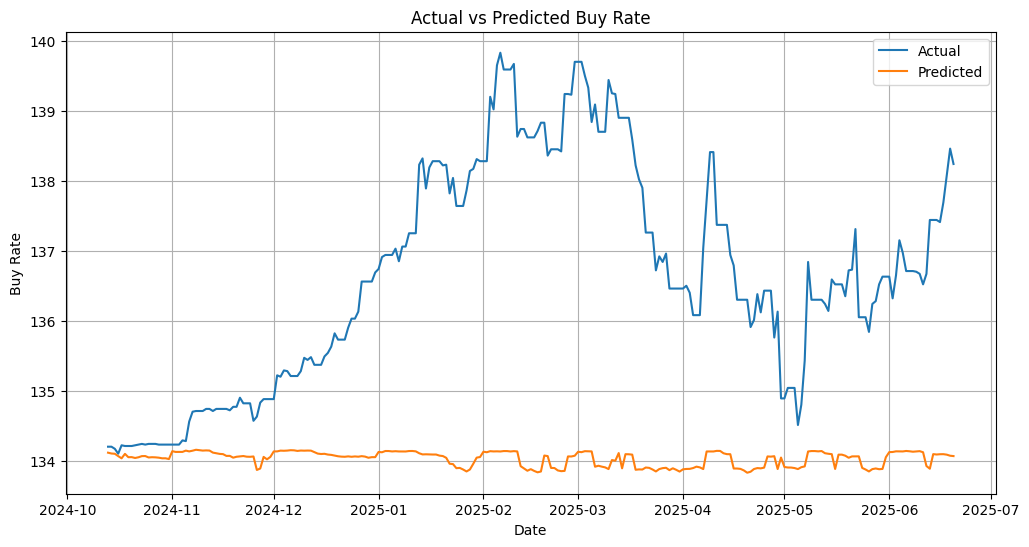

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
# 13. Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 14. Predict
y_pred = model.predict(X_test)

# 15. Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
# print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# 16. Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[y_test.index], y_test, label='Actual')
plt.plot(df['date'].iloc[y_test.index], y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Buy Rate")
plt.xlabel("Date")
plt.ylabel("Buy Rate")
plt.grid()
plt.show()

In [99]:
df['baseline_pred'] = df['buy_rate'].shift(1)

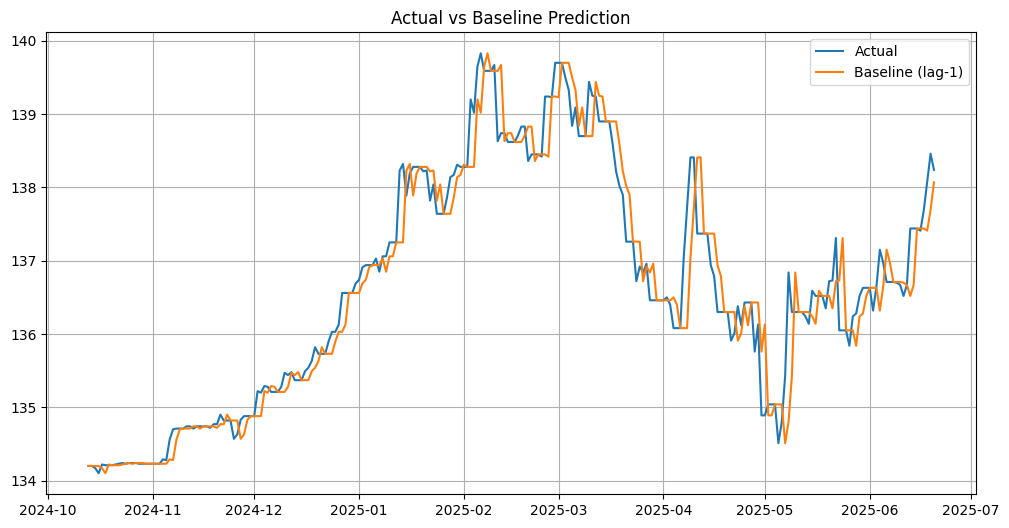

In [100]:
plt.figure(figsize=(12,6))
plt.plot(df['date'].iloc[y_test.index], y_test, label='Actual')
plt.plot(df['date'].iloc[y_test.index], df['baseline_pred'].iloc[y_test.index], label='Baseline (lag-1)')
plt.legend()
plt.title("Actual vs Baseline Prediction")
plt.grid()
plt.show()

In [ ]:
spark.stop()